#### Networks and Simulations (example 01)

In [1]:
import memocell as me
import numpy as np
import matplotlib.pyplot as plt
import pickle

/Users/m651s/Documents/Studium/PhD/01_projects/memo_cell/memocell/memocell/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


##### Cell activation division process

We specify a network with a Phase-type activation and Erlang type division reaction. Afterwards we simulate the network with some specific numerical parameters in terms of its moments (mean, variance, covariance) and stochastically.

In [2]:
# number of hidden steps for a phase-type (two parallel 
# Erlang channels) activation reaction
n_d4 = 4
n_d2 = 2

# number of steps for Erlang type division reaction
# NOTE: this implies CV = 1/sqrt(n_l) = 1/sqrt(3) ≈ 0.58
# (where CV is coefficient of variation = sqrt(variance)/mean)
n_l = 3

# define a topology for a memocell network
# X_t and Y_t are inactivated and activated cells, respectively
# only activated cells (Y_t) can then divide
topology = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': n_d4},
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': n_d2},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': n_l}
    ]

# here, memocell constructs the network
net = me.Network('my_net')
net.structure(topology)

# NOTE: a Markov model is obtained if one sets all reaction steps to 1
# (memoryless description, no unobserved/hidden variables, exponential waiting times only)

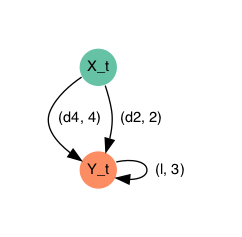

In [3]:
# plot the main/observable layer of a memocell network
# all Erlang type reaction or channels are denoted as tuple (rate, steps)
# 1/rate is the mean Erlang waiting time for each channel (in isolation)
me.plots.net_main_plot(net);

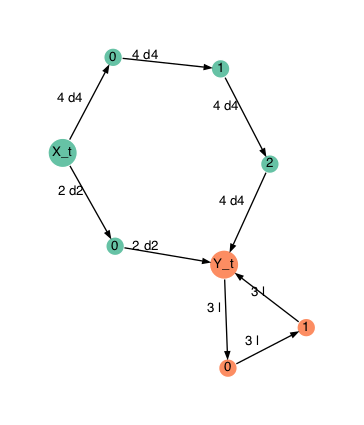

In [4]:
# plot the hidden (Markov) layer of the network
# this shows all substeps and hidden variables to construct the waiting times
# NOTE: the observable layer variables are the sum of all their 
# respective hidden variables (with the same color)
# NOTE: each cell type has a "centric" hidden node where reaction 
# channels start and end (with larger size and X_t and Y_t names)
me.plots.net_hidden_plot(net);

In [5]:
# now, we specify some numerical values for the rates
theta_d4 = 0.03
theta_d2 = 0.04

# then, the reaction waiting time distributions can be plotted
# (times of a single cell going through the activation or division modules)
act_times = np.linspace(0.0, 60.0)

# extract the phase-type parameters (initial probabilities and 
# generator matrix) and plot the probability density function (pdf)
alpha, S = me.utils.phase_type_from_parallel_erlang2(theta_d4, theta_d2, n_d4, n_d2)
act_times_pdf = me.utils.phase_type_pdf(alpha, S, act_times)
# we obtain a non-exponential and non-Erlang, quite long-tailed, distribution

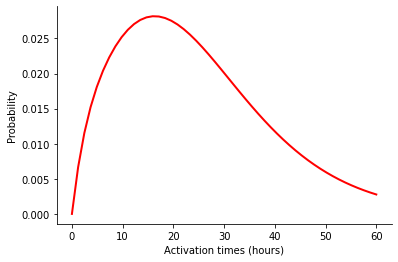

In [6]:
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(act_times, act_times_pdf, color='red', lw=2)
plt.ylabel('Probability')
plt.xlabel('Activation times (hours)');

In [7]:
# for the division reaction, we obtain a faster and more controlled / tight
# waiting time distribution; mean waiting time = 1/theta_l = 1/0.06 ≈ 16.7
theta_l = 0.06 

div_times = np.linspace(0.0, 60.0)
alpha, S = me.utils.phase_type_from_erlang(theta_l, n_l)
div_times_pdf = me.utils.phase_type_pdf(alpha, S, div_times)

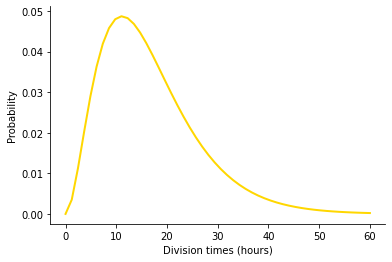

In [8]:
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(div_times, div_times_pdf, color='gold', lw=2)
plt.ylabel('Probability')
plt.xlabel('Division times (hours)');

In [9]:
# now, we simulate the overall cell number dynamics of the network with 
# the specified waiting time distributions

# moment simulations: simulate the mean, variance and covariance 
# of the cell type numbers
# NOTE: the first "sim.simulate" call may take a bit, because symbolic derivations
# have to be done once; subsequent runs are much faster

# here, the main nodes X and Y are our variables to be simulated
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

# use the numerical rates from before
theta_values = {'l': theta_l, 'd4': theta_d4, 'd2': theta_d2}
time_values = np.linspace(0.0, 54.0)

# initial value type specifies how the cells are distributed 
# on the hidden layer at t=0 (initial condition); options 
# are 'synchronous' (all cells are placed at the start/centric hidden node)
# or 'uniform' (cells are distributed uniformly on the hidden layer)
initial_values_type = 'synchronous'

# specify the initial condition for the moments; our process starts
# always with one single X cell, hence we use a mean of 1.0 ((X,) tuple)
# and variances ((X,X) and (Y,Y) tuples) and covariance ((X,Y) tuple) of 0.0
initial_values_moments = {('X_t',): 1.0, ('Y_t',): 0.0,
                          ('X_t','X_t'): 0.0, ('X_t','Y_t'): 0.0, ('Y_t','Y_t'): 0.0}

# memocell then derives the moment equations symbolically and 
# integrates them numerically with the above settings
sim = me.Simulation(net)
sim.simulate('moments', variables, theta_values, time_values,
            initial_values_type, initial_moments=initial_values_moments);

# NOTE: "simulate" has the optional keyword "sim_mean_only" which can be used 
# to skip variance and covariance computations (set to True); if the mean level
# is all that is needed, this option can speed up things a lot

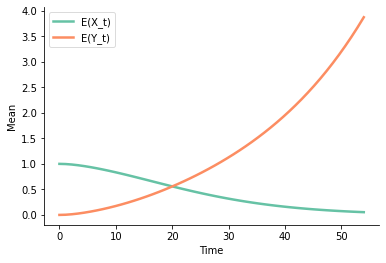

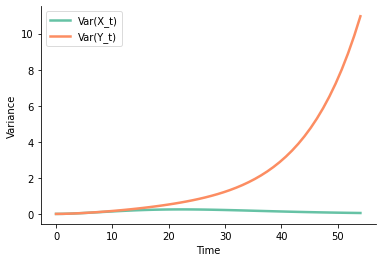

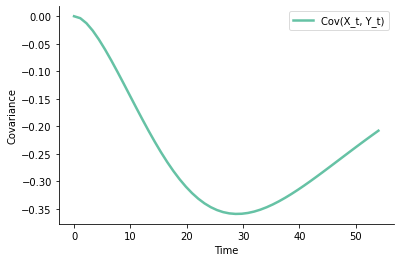

In [10]:
# the results are plotted
me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim);

In [11]:
# stochastic simulations: simulate single stochastic realisations 
# of the process

# the parameters from above are re-used, except now we
# need cell numbers to specify an initial distribution at t=0
initial_values_gillespie = {'X_t': 1, 'Y_t': 0}

# memocell derives a gillespie algorithm on the hidden layer 
# to obtain the observable cell numbers
sim = me.Simulation(net)
sim.simulate('gillespie', variables, theta_values, time_values,
            initial_values_type, initial_gillespie=initial_values_gillespie);

# NOTE: the moment and stochastic simulations directly correspond to 
# each other; mean, variance and covariance statistics of many 
# stochastic simulations will converge to the exact moment simulations 
# from above

# NOTE: above initial values would specify a "deterministic" 
# distribution if used for many repeated simulations; to implement 
# a non-deterministic initial distribution, one can simply draw 
# random numbers for the initial values at each iteration (and 
# analogously use non-zero variances/covariances for the initial 
# moments in the moment simulations)

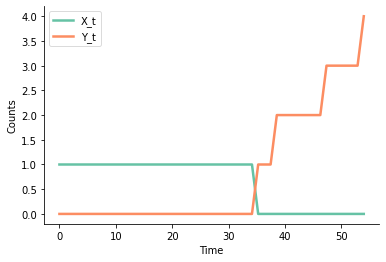

In [12]:
# plot the one stochastic realisation
me.plots.sim_counts_plot(sim);

##### Other reaction types
Below other reaction types available in MemoCell are briefly introduced. Of course, they can be combined for multi-reaction networks and also implemented as phase-type distributions (two or more parallel channels).

*Notes*:
- reaction types have to be provided by specific strings between start (*S*) and end (*E*) node, see below
- for influx and efflux reactions one has to use the environment node "env".

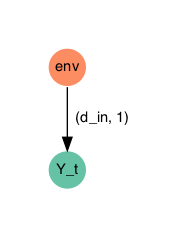

In [13]:
# influx or (constant-rate) cell birth
# 'type': '-> E'
t = [
    {'start': 'env', 'end': 'Y_t', 'rate_symbol': 'd_in', 'type': '-> E', 'reaction_steps': 1}
    ]

net = me.Network('my_net')
net.structure(t)

me.plots.net_main_plot(net);

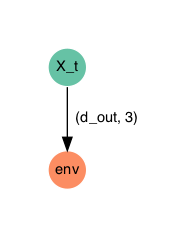

In [14]:
# efflux or cell death
# 'type': 'S ->'
t = [
    {'start': 'X_t', 'end': 'env', 'rate_symbol': 'd_out', 'type': 'S ->', 'reaction_steps': 3}
    ]

net = me.Network('my_net')
net.structure(t)

me.plots.net_main_plot(net);

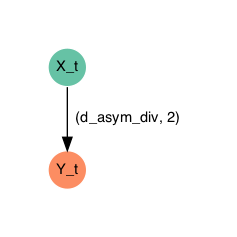

In [15]:
# asymmetric division
# 'type': 'S -> S + E'
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd_asym_div', 'type': 'S -> S + E', 'reaction_steps': 2}
    ]

net = me.Network('my_net')
net.structure(t)

# NOTE that the reaction is displayed as a simple link between X and Y currently
me.plots.net_main_plot(net);

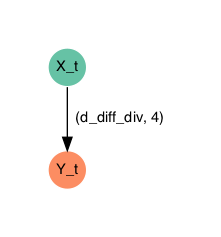

In [16]:
# symmetric differentiating division
# 'type': 'S -> E + E'
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd_diff_div', 'type': 'S -> E + E', 'reaction_steps': 4}
    ]

net = me.Network('my_net')
net.structure(t)

# NOTE that the reaction is displayed as a simple link between X and Y currently
me.plots.net_main_plot(net);